<a href="https://colab.research.google.com/github/jeremi0214/DATA425_Assignment2/blob/main/DATA425_assignment2_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from tensorflow.keras.applications import MobileNetV2, DenseNet121, NASNetMobile, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nasnet
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, linregress

In [22]:
# === CONFIGURATION ===
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
NUM_CLASSES = 102

In [23]:
# === BACKBONES TO EVALUATE ===
MODELS = {
    "MobileNetV2": (MobileNetV2, preprocess_mobilenet),
    "DenseNet121": (DenseNet121, preprocess_densenet),
    "NASNetMobile": (NASNetMobile, preprocess_nasnet),
    "ResNet50": (ResNet50, preprocess_resnet),
}

# Hardcoded Top-1 accuracy from ImageNet
imagenet_top1 = {
    "MobileNetV2": 71.3,
    "DenseNet121": 75.0,
    "NASNetMobile": 74.4,
    "ResNet50": 74.9,
}

In [24]:
# === LOAD DATASET ===
def load_dataset(name="oxford_flowers102", img_size=(224, 224), batch_size=BATCH_SIZE):
    def preprocess(example):
        image = tf.image.resize(example["image"], img_size)
        label = example["label"]
        return image, label

    train_ds = tfds.load(name, split="train", as_supervised=False)
    val_ds = tfds.load(name, split="validation", as_supervised=False)
    test_ds = tfds.load(name, split="test", as_supervised=False)

    train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [25]:
# === EXTRACT FEATURES ===
def extract_features(model_fn, dataset, preprocess_fn, input_shape=(224, 224, 3)):
    base_model = model_fn(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base_model.trainable = False

    features, labels = [], []

    for batch in dataset:
        imgs, lbls = batch
        imgs = preprocess_fn(imgs)
        feats = base_model(imgs, training=False)
        features.append(feats.numpy())
        labels.append(lbls.numpy())

    X = np.concatenate(features)
    y = np.concatenate(labels)
    return X, y

In [26]:
# === TRAIN LOGISTIC REGRESSION WITH L2 REGULARIZATION PATH ===
def train_logistic_regression(X_train, y_train, X_val, y_val):
    Cs = np.logspace(-6, 5, 45)
    best_acc = 0
    best_model = None
    warm_start_model = None

    for i, C in enumerate(Cs):
        model = LogisticRegression(
            solver='lbfgs',
            penalty='l2',
            C=C,
            max_iter=1000,
            warm_start=True if i > 0 else False
        )

        if warm_start_model:
            model.coef_ = warm_start_model.coef_.copy()
            model.intercept_ = warm_start_model.intercept_.copy()

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        val_acc = accuracy_score(y_val, val_preds)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model

        warm_start_model = model

    return best_model, best_acc

In [27]:
from re import X
# === PIPELINE ===
def run_comparison():
    train_ds, val_ds, test_ds = load_dataset("oxford_flowers102", img_size=IMG_SIZE, batch_size=BATCH_SIZE)
    val_accs = {}
    test_accs = {}

    for name, (model_fn, preprocess_fn) in MODELS.items():
        print(f"\n=== Processing {name} ===")
        X_train, y_train = extract_features(model_fn, train_ds, preprocess_fn)
        X_val, y_val = extract_features(model_fn, val_ds, preprocess_fn)
        X_test, y_test = extract_features(model_fn, test_ds, preprocess_fn)

        best_model, val_acc = train_logistic_regression(X_train, y_train, X_val, y_val)
        test_preds = best_model.predict(X_test)
        test_acc = accuracy_score(y_test, test_preds)

        print(f"Validation Accuracy for {name}: {val_acc:.4f}")
        print(f"Test Accuracy for {name}: {test_acc:.4f}")

        val_accs[name] = val_acc
        test_accs[name] = test_acc

    print("\n=== Summary of Validation Accuracies ===")
    for name, acc in val_accs.items():
        print(f"{name}: {acc:.4f}")

    print("\n=== Summary of Test Accuracies ===")
    for name, acc in test_accs.items():
        print(f"{name}: {acc:.4f}")

    return val_accs, test_accs

In [28]:
# === Plot the correlation ===
def plot_correlation(test_acc_dict, top1_dict, ax=None):
    # Match model names and get aligned data
    model_names = [name for name in test_acc_dict.keys() if name in top1_dict.keys()]

    transfer_acc = [test_acc_dict[m] * 100 for m in model_names]
    imagenet_acc = [top1_dict[m] for m in model_names]

    # Compute Pearson correlation
    r, p = pearsonr(imagenet_acc, transfer_acc)

    # Create DataFrame
    df = pd.DataFrame({
        "Model": model_names,
        "ImageNet_Top1": imagenet_acc,
        "Transfer_Acc": transfer_acc
    })

    # Plot with seaborn regression
    if ax is None:
      fig, ax = plt.subplot(figsize=(6, 5))
    sns.set(style="whitegrid")

    # Regression line with 95% CI
    sns.regplot(
        x="ImageNet_Top1", y="Transfer_Acc", data=df,
        ax=ax, scatter=True, color="royalblue", ci=95,
        line_kws={"color": "royalblue"}
    )

    # Scatter points with custom markers
    markers = ['o', 's', '^', 'v', 'P', '*', 'X', 'D']
    for i, row in df.iterrows():
        ax.scatter(row["ImageNet_Top1"], row["Transfer_Acc"],
                    s=80, marker=markers[i % len(markers)],
                    edgecolor="black", facecolor="white")
        ax.text(row["ImageNet_Top1"] + 0.2, row["Transfer_Acc"],
                 row["Model"], fontsize=9)

    # Labels and title
    ax.set_xlabel("ImageNet Top-1 Accuracy (%)")
    ax.set_ylabel("Transfer Accuracy (%)")
    ax.set_title(f"Logistic Regression\nPearson r = {r:.3f}, p = {p:.3g}")

    ax.set_xlim(min(imagenet_acc) - 1, max(imagenet_acc) + 2)
    ax.set_ylim(min(transfer_acc) - 2, max(transfer_acc) + 2)

    # Add legend
    ax.legend(handles=handles, loc="lower right", fontsize=8, frameon=True)

In [29]:
def plot_logodds_correlation(test_acc_dict, top1_dict):
    # Match model names
    model_names = [name for name in test_acc_dict.keys() if name in top1_dict.keys()]

    transfer_acc = np.array([test_acc_dict[m] for m in model_names])
    imagenet_acc = np.array([top1_dict[m] for m in model_names])

    # Convert to log-odds
    eps = 1e-5  # avoid division by zero or log(0)
    log_odds = np.log((transfer_acc + eps) / (1 - transfer_acc + eps))

    # Compute Pearson correlation
    r, p = pearsonr(imagenet_acc, log_odds)

    # Create DataFrame
    df = pd.DataFrame({
        "Model": model_names,
        "ImageNet_Top1": imagenet_acc,
        "LogOdds_Transfer": log_odds
    })

    # Plot with seaborn
    plt.figure(figsize=(6, 5))
    sns.set(style="whitegrid")

    sns.regplot(
        x="ImageNet_Top1", y="LogOdds_Transfer", data=df, scatter=False,
        line_kws={"color": "darkgreen"}, ci=95
    )

    # Custom scatter points and labels
    markers = ['o', 's', '^', 'v', 'P', '*', 'X', 'D']
    for i, row in df.iterrows():
        plt.scatter(row["ImageNet_Top1"], row["LogOdds_Transfer"],
                    s=80, marker=markers[i % len(markers)],
                    edgecolor="black", facecolor="white", label=row["Model"])
        plt.text(row["ImageNet_Top1"] + 0.2, row["LogOdds_Transfer"],
                 row["Model"], fontsize=9)

    plt.xlabel("ImageNet Top-1 Accuracy (%)")
    plt.ylabel("Transfer Accuracy (log-odds × 100)")
    plt.title(f"Log-Odds of Transfer Accuracy\nPearson r = {r:.3f}, p = {p:.3g}")

    plt.tight_layout()
    plt.show()


=== Processing MobileNetV2 ===
Validation Accuracy for MobileNetV2: 0.8441
Test Accuracy for MobileNetV2: 0.8014

=== Processing DenseNet121 ===
Validation Accuracy for DenseNet121: 0.8608
Test Accuracy for DenseNet121: 0.8501

=== Processing NASNetMobile ===
Validation Accuracy for NASNetMobile: 0.6931
Test Accuracy for NASNetMobile: 0.6562

=== Processing ResNet50 ===
Validation Accuracy for ResNet50: 0.8775
Test Accuracy for ResNet50: 0.8492

=== Summary of Validation Accuracies ===
MobileNetV2: 0.8441
DenseNet121: 0.8608
NASNetMobile: 0.6931
ResNet50: 0.8775

=== Summary of Test Accuracies ===
MobileNetV2: 0.8014
DenseNet121: 0.8501
NASNetMobile: 0.6562
ResNet50: 0.8492


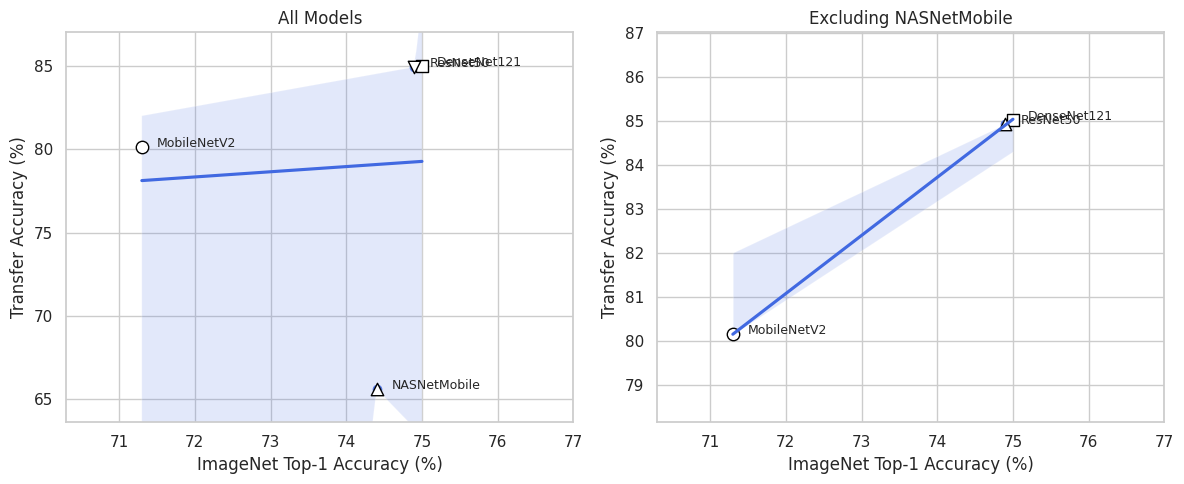

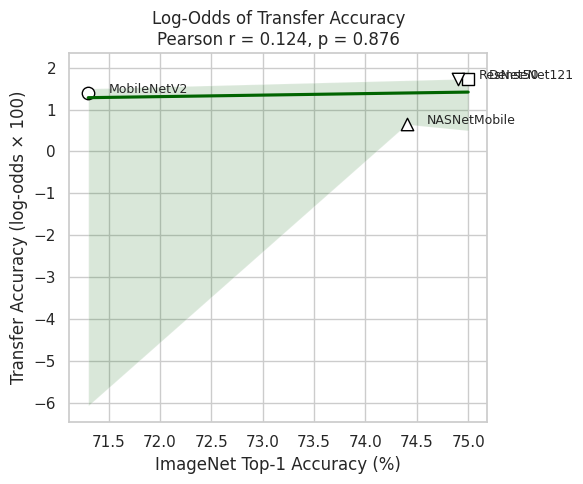

In [30]:
# === RUN ===
if __name__ == "__main__":
    val_accs, test_accs = run_comparison()

    # Create copy without NASNetMobile
    test_accs_no_nasnet = {k: v for k, v in test_accs.items() if k != "NASNetMobile"}
    # Prepare side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    plot_correlation(test_accs, imagenet_top1, ax=axes[0])
    axes[0].set_title("All Models")

    plot_correlation(test_accs_no_nasnet, imagenet_top1, ax=axes[1])
    axes[1].set_title("Excluding NASNetMobile")

    plt.tight_layout()
    plt.show()

    plot_logodds_correlation(test_accs, imagenet_top1)